In [1]:
import sys
sys.path.append('/opt/conda/pkgs')
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4506eccf78279d93d0e8a34c035e91c5_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/6bda807e3967eae797c7b1b9eeaee8db_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c2a47d89d1d34e789fdf782557bb7194_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c6c5514ada15b890fb27d1e36371554c_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/d964a294c2d0fef56a434c021026281e_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/e1c932db5cd4271709e54d8028824bc9_/lib/python3.12/site-packages")
import gzip, json
from Bio import SeqIO
import scipy.sparse as sp
from collections import Counter
import numpy as np
import pandas as pd
fasta_gz_file = '/home/miaocj/docker_dir/kNN-overlap-finder/data/regional_reads/Ecoli/all/ONT/reads.fasta.gz'
paf_gz_file = '/home/miaocj/docker_dir/kNN-overlap-finder/data/regional_reads/Ecoli/all/ONT/alignment.paf.gz'
with gzip.open(paf_gz_file, "rt") as file:
    max_values = {}  
    for row in file:  
        columns = row.strip().split('\t') 
        query_id = columns[0]  
        match_bases = int(columns[9]) 
        max_values[query_id] = columns 
        if query_id in max_values:  
            if match_bases > int(max_values[query_id][9]):  
                max_values[match_bases] = columns
        else:  
            continue

In [2]:
import sys
import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
from typing import Mapping  
import mmh3
from itertools import chain  
import sharedmem

In [3]:
sys.path.append("scripts")
sys.path.append("../../scripts")
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges


/home/miaocj/docker_dir/kNN-overlap-finder/scripts/../lib


In [4]:
import numpy as np  
import collections  
from typing import Mapping  
from sklearn.neighbors import NearestNeighbors  
from scipy.spatial.distance import hamming  
import mmh3  
max_n_neighbors = 20
MAX_SAMPLE_SIZE = int(1e9)
k_values = np.arange(2, max_n_neighbors + 1)


In [5]:
npz_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/human/HLA/ONT_R9/kmer_k16/feature_matrix.npz"
tsv_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/human/HLA/ONT_R9/kmer_k16/metadata.tsv.gz"
json_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/human/HLA/ONT_R9/kmer_k16/read_features.json.gz"

meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}
feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

read_ids = np.array(list(read_features))

In [6]:
feature_matrix.shape

(12926, 2040722)

In [7]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

(12926, 324674, 25276, 2)

In [42]:
def _get_table(
    kmer_num: int,seed: int) -> Mapping[int,list]:
    rng = np.random.default_rng(seed)
    binary_array = rng.integers(0, 2, size=kmer_num*3200,dtype=np.int8)
    hash_table =np.reshape(binary_array,(kmer_num,3200))
    hash_table[hash_table == 0] = -1 
    return hash_table

In [43]:
hash_table=_get_table(2040722,2040722)

In [44]:
import pynear
_simhash = feature_matrix@hash_table
simhash = np.where(_simhash > 0, 1, 0)
simhash_8bit = np.packbits(simhash,axis=-1)
# vptree = pynear.VPTreeBinaryIndex()
# vptree.set(simhash_8bit)
# vptree_indices, vptree_distances = vptree.searchKNN(simhash_8bit, 21)

In [ ]:
##转化为二进制字节
simhash.tobytes()

In [52]:
from simhash import Simhash,SimhashIndex

In [103]:
class SimhashIndex(object):

    def __init__(self, objs, f=64, k=2, log=None):
        """
        `objs` is a list of (obj_id, simhash)
        obj_id is a string, simhash is an instance of Simhash
        `f` is the same with the one for Simhash
        `k` is the tolerance
        """
        self.k = k
        self.f = f
        count = len(objs)

        if log is None:
            self.log = logging.getLogger("simhash")
        else:
            self.log = log

        self.log.info('Initializing %s data.', count)

        self.bucket = collections.defaultdict(set)

        for i, q in enumerate(objs):
            if i % 10000 == 0 or i == count - 1:
                self.log.info('%s/%s', i + 1, count)

            self.add(*q)

    def get_near_dups(self, simhash):
        """
        `simhash` is an instance of Simhash
        return a list of obj_id, which is in type of str
        """
        assert simhash.f == self.f

        ans = set()

        for key in self.get_keys(simhash):
            dups = self.bucket[key]
            self.log.debug('key:%s', key)
            if len(dups) > 200:
                self.log.warning('Big bucket found. key:%s, len:%s', key, len(dups))

            for dup in dups:
                sim2, obj_id = dup.split(',', 1)
                sim2 = Simhash(int(sim2, 16), self.f)

                d = simhash.distance(sim2)
                if d <= self.k:
                    ans.add(obj_id)
        return list(ans)

    def add(self, obj_id, simhash):
        """
        `obj_id` is a string
        `simhash` is an instance of Simhash
        """
        assert simhash.f == self.f

        for key in self.get_keys(simhash):
            v = '%x,%s' % (simhash.value, obj_id)
            self.bucket[key].add(v)

    def delete(self, obj_id, simhash):
        """
        `obj_id` is a string
        `simhash` is an instance of Simhash
        """
        assert simhash.f == self.f

        for key in self.get_keys(simhash):
            v = '%x,%s' % (simhash.value, obj_id)
            if v in self.bucket[key]:
                self.bucket[key].remove(v)

    @property
    def offsets(self):
        """
        You may optimize this method according to <http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/33026.pdf>
        """
        return [self.f // (self.k + 1) * i for i in range(self.k + 1)]

    def get_keys(self, simhash):
        for i, offset in enumerate(self.offsets):
            if i == (len(self.offsets) - 1):
                m = 2 ** (self.f - offset) - 1
            else:
                m = 2 ** (self.offsets[i + 1] - offset) - 1
            c = simhash.value >> offset & m
            yield '%x:%x' % (c, i)

    def bucket_size(self):
        return len(self.bucket)

In [45]:
import collections
import hashlib
import logging
import numbers
import re
import sys
class Simhash(object):
    # Constants used in calculating simhash. Larger values will use more RAM.
    large_weight_cutoff = 50
    batch_size = 200

    def __init__(
            self, value, f=64, log=None
    ):
        if f % 8:
            raise ValueError('f must be a multiple of 8')

        self.f = f
        self.f_bytes = f // 8
        self.value = None
        if log is None:
            self.log = logging.getLogger("simhash")
        else:
            self.log = log

        if isinstance(value, Simhash):
            self.value = value.value
        elif isinstance(value, numbers.Integral):
            self.value = value
        else:
            raise Exception('Bad parameter with type {}'.format(type(value)))

In [126]:
onesim = Simhash(binary_simhash[1],f=3200)

In [130]:
len(bin(onesim.value))

64

In [64]:
obj = [(k,Simhash(v,f=3200)) for k,v in enumerate(binary_simhash)]

In [57]:
int(binary_simhash[1],2)

3320380472739891658

In [28]:
import logging
logger = logging.getLogger("my_custom_logger")
logger.setLevel(logging.INFO)

In [111]:
mysim = SimhashIndex(obj,f=3200,k=15,log=logger)

In [113]:
len(dup)

4

In [117]:
dup = mysim.get_near_dups(Simhash(binary_simhash[4],f=3200))

Big bucket found. key:0:1, len:7637
Big bucket found. key:0:2, len:7637
Big bucket found. key:0:3, len:7637
Big bucket found. key:0:4, len:7637
Big bucket found. key:0:5, len:7637
Big bucket found. key:0:6, len:7637
Big bucket found. key:0:7, len:7637
Big bucket found. key:0:8, len:7637
Big bucket found. key:0:9, len:7637
Big bucket found. key:0:a, len:7637
Big bucket found. key:0:b, len:7637
Big bucket found. key:0:c, len:7637
Big bucket found. key:0:d, len:7637
Big bucket found. key:0:e, len:7637
Big bucket found. key:0:f, len:7637


In [45]:
vptree = pynear.VPTreeBinaryIndex()
vptree.set(simhash_8bit)
vptree_indices, vptree_distances = vptree.searchKNN(simhash_8bit, 21)

In [37]:
distance1 = list(itertools.chain(*vptree_distances))
di = collections.Counter(distance1)

Text(0, 0.5, 'frequency')

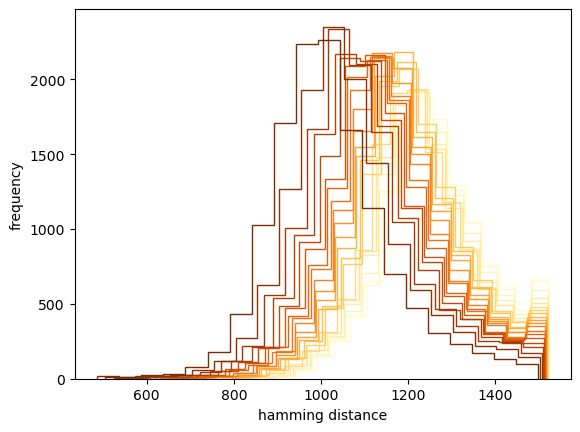

In [78]:
import matplotlib as mpl
import matplotlib.pyplot as plt
for i in range(0,max_n_neighbors):
    dis = [x[i] for x in vptree_distances]
    # count = Counter(dis)
    # x_dis = count.keys()
    # y_frequency=count.values()
    plt.hist(dis,histtype='step',bins=20,color=purple_to_pink[i])
plt.xlabel('hamming distance')
plt.ylabel('frequency')

In [ ]:
import seaborn as sns
purple_to_pink = sns.color_palette("PuRd", 20).as_hex()

In [ ]:
sns.diverging_palette(145, 300, s=60)

TypeError: diverging_palette() got an unexpected keyword argument 'n_colors'

In [65]:
len(purple_to_pink)

19

Text(0, 0.5, 'frequency')

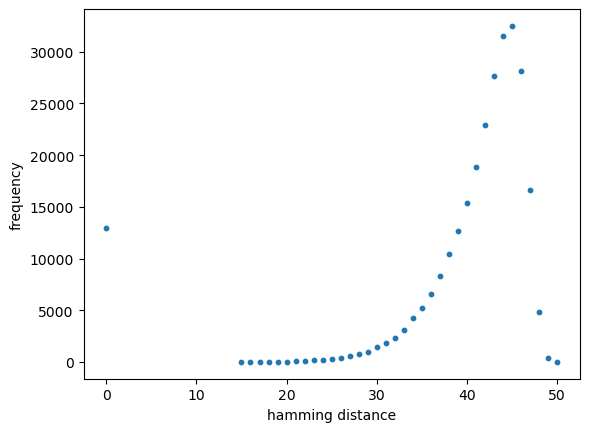

In [ ]:
import matplotlib.pyplot as plt
dis = di.keys()
times = di.values()
plt.scatter(dis,times,s=10)
#plt.ylim(0,1000)
plt.xlabel('hamming distance')
plt.ylabel('frequency')

In [12]:
import scipy.sparse as sp
simhash_32bit = simhash_8bit.astype(np.uint32)
all_matrix = []
for i in range(0,200):
    data=[1]*12926
    row_ind = list(range(0,12926))
    one_column = simhash_8bit[:,2*i:2*i+2]
    one_column_diff = one_column*[1,2**8]
    col_ind = one_column_diff.sum(axis=1)
    one_column_matrix = sp.csr_matrix(
        (data, (row_ind, col_ind)), shape=(12926,65536))
    all_matrix.append(one_column_matrix)
x= sp.hstack(all_matrix)
cooccurrence_matrix = x.dot(x.T)

In [13]:
indices = np.nonzero(x)

In [22]:
columns_non_unique = indices[1]
unique_columns = sorted(set(columns_non_unique))
x_without_zero_col = x.tocsc()[:,unique_columns]

In [23]:
cooccurrence_matrix = x_without_zero_col.dot(x_without_zero_col.T)

In [24]:
cooccurrence_matrix

<Compressed Sparse Column sparse matrix of dtype 'int64'
	with 814424 stored elements and shape (12926, 12926)>

In [29]:
one_column_diff = one_column[:,:2]*[1,2**8]
one_column_diff.sum(axis=1).max()

65532

In [25]:
cooccurrence_matrix.sum()/(cooccurrence_matrix.shape[0]*cooccurrence_matrix.shape[1])

0.020378093858830885

In [61]:
nonzero_indices = list(zip(*cooccurrence_matrix.nonzero()))
len(nonzero_indices)

138644928

In [33]:
n_neighbors=20
min_cooccurence_count=1
neighbor_dict = collections.defaultdict(dict)
nonzero_indices = list(zip(*cooccurrence_matrix.nonzero()))
for i, j in nonzero_indices:
    if i >= j:
        continue

    count = cooccurrence_matrix[i, j]
    neighbor_dict[i][j] = count
    neighbor_dict[j][i] = count

# Construct neighbor matrix
n_rows = feature_matrix.shape[0]
nbr_matrix = np.empty((n_rows, n_neighbors), dtype=np.int64)
nbr_matrix[:, :] = -1
for i in range(n_rows):
    row_nbr_dict = {
        j: count
        for j, count in neighbor_dict[i].items()
        if count >= min_cooccurence_count
    }
    neighbors = list(
        sorted(row_nbr_dict, key=lambda x: row_nbr_dict[x], reverse=True)
    )[:n_neighbors]
    nbr_matrix[i, : len(neighbors)] = (
        neighbors  # len(neighbors) could be smaller than n_neighbors
    )

In [34]:
##min_cooccurence_count=12
import collections
collections.Counter(nbr_matrix.flatten().tolist())

Counter({218: 237,
         219: 197,
         698: 178,
         1318: 177,
         126: 172,
         232: 166,
         1319: 165,
         1683: 164,
         970: 163,
         348: 163,
         500: 163,
         501: 163,
         699: 162,
         189: 162,
         785: 162,
         1133: 156,
         127: 154,
         73: 151,
         1980: 151,
         1132: 151,
         784: 146,
         258: 144,
         971: 143,
         787: 143,
         1753: 140,
         188: 139,
         1752: 138,
         233: 137,
         340: 135,
         929: 133,
         605: 131,
         259: 131,
         349: 131,
         1356: 130,
         72: 130,
         563: 129,
         705: 128,
         1631: 127,
         261: 127,
         976: 126,
         1330: 126,
         1994: 125,
         722: 124,
         495: 124,
         1357: 124,
         260: 124,
         1630: 124,
         723: 123,
         670: 123,
         1640: 123,
         786: 123,
         1030: 123

In [36]:
one_column = simhash_8bit[:,:1]
col_ind = one_column.flatten()

In [7]:
def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int8) 
    hash_array = np.where(hash_array == 0, -1, 1) 
    return hash_array
def _get_table(
    kmer_num: list,  
    *,
    seed: int,
    repeat=100) -> Mapping[int,list]:  
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  
    hash_table = np.empty((kmer_num,repeat,32),dtype=np.int8)  
    for flag,seed in enumerate(hash_seeds):
        for kmer_index in range(kmer_num):
            hash_table[kmer_index,flag,:]=_hash(kmer_index, seed=seed)
            new_hash_table=np.reshape(hash_table,(kmer_num,32*repeat))
    return new_hash_table
def get_simhash(read_features,hash_table):
    all_read_simhash = []
    for read_kmer in read_features.values():
        one_read_hash = np.sum(hash_table[read_kmer,:],axis=0)
        simhash = np.where(one_read_hash > 0, 1, 0)
        all_read_simhash.append(simhash)
    reads_simhash_array = np.array(all_read_simhash)
    return reads_simhash_array
hash_table = _get_table(feature_matrix.shape[1],seed = 15232,repeat=100)

In [8]:
def get_simhash(read_features,hash_table):
    all_read_simhash = []
    for read_kmer in read_features.values():
        one_read_hash = np.sum(hash_table[read_kmer,:],axis=0)
        simhash = np.where(one_read_hash > 0, 1, 0)
        all_read_simhash.append(simhash)
    reads_simhash_array = np.array(all_read_simhash)
    return reads_simhash_array
def hamming_distance(x, y):  
    return np.count_nonzero(x != y)

In [9]:
concat_simhash = get_simhash(read_features,hash_table)

In [12]:
nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
nbrs.fit(concat_simhash)  
indices = nbrs.kneighbors(concat_simhash,return_distance=False)
nbr_indices = indices[:, 1:]

In [40]:
nbr_indices= np.array(vptree_indices)[:,:-1][:,::-1]
df_rows = []
for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
    stats = { "n_neighbors": k}
    stats = {"description":'SimHash_TF-IDF', "n_neighbors": k, "repeat_time": 100,
                **graph_stats}
    df_rows.append(stats)
df_tfidf = pd.DataFrame(df_rows)

In [41]:
df_tfidf

,description,n_neighbors,repeat_time,precision,nr_precision,recall,nr_recall,singleton_count,singleton_fraction,N50,continuity
0,SimHash_TF-IDF,2,100,0.701480,0.169445,0.043939,0.136335,4114,0.318273,112,0.017329
1,SimHash_TF-IDF,3,100,0.665092,0.149673,0.060713,0.175502,3199,0.247486,648,0.100263
2,SimHash_TF-IDF,4,100,0.632853,0.134520,0.075420,0.205927,2744,0.212285,941,0.145598
3,SimHash_TF-IDF,5,100,0.605115,0.122537,0.088901,0.231247,2435,0.188380,1852,0.286554
4,SimHash_TF-IDF,6,100,0.581255,0.113474,0.101351,0.254154,2223,0.171979,3036,0.469751
5,SimHash_TF-IDF,7,100,0.557858,0.106149,0.112417,0.274767,2067,0.159910,3055,0.472691
6,SimHash_TF-IDF,8,100,0.536572,0.099370,0.122689,0.291858,1962,0.151787,3071,0.475166
7,SimHash_TF-IDF,9,100,0.516703,0.093855,0.132108,0.308237,1862,0.144051,4244,0.656661
8,SimHash_TF-IDF,10,100,0.498359,0.088298,0.140757,0.320343,1778,0.137552,4264,0.659756
9,SimHash_TF-IDF,11,100,0.480715,0.083411,0.148715,0.331461,1709,0.132214,4278,0.661922


In [ ]:

# mp_concat_simhash = get_simhash(read_features,feature_matrix,hash_table,tf = None,idf = None,processes=8) 
# nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
# nbrs.fit(mp_concat_simhash)  
# indices = nbrs.kneighbors(mp_concat_simhash,return_distance=False)
# nbr_indices = indices[:, 1:]

df_rows = []
for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
    stats = { "n_neighbors": k}
    stats = {"description":'SimHash_TF-IDF', "n_neighbors": k, "repeat_time": 100,
                **graph_stats}
    df_rows.append(stats)
df_tfidf = pd.DataFrame(df_rows)
#df_tfidf.to_csv('/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/human/HLA/ONT_R9/kmer_k16/SimHash_None_None_overlap_stat.tsv',sep='\t')

In [ ]:
ref_reads_simhash_array = get_simhash(ref_read_features,hash_table)
def hamming_distance(x, y):  
    return np.count_nonzero(x != y)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto', metric=hamming_distance)
nbrs.fit(ref_reads_simhash_array)
indices = nbrs.kneighbors(que_reads_simhash_array,return_distance=False)
print("done\nevaluates")

In [12]:
hash_table.shape

In [13]:
feature_matrix.shape

In [14]:
simhash = feature_matrix@hash_table

In [16]:
simhash

In [35]:
def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int8) 
    hash_array = np.where(hash_array == 0, -1, 1)  
    return hash_array  

def _get_table(
    read_features: list,  
    feature_matrix: list,
    *,
    seed: int,
    tf:bool,
    idf:bool,
    repeat=100) -> Mapping[int,list]:  
    
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  

    kmer_num = feature_matrix.shape[1]
    hash_table = np.empty((kmer_num,repeat,32),dtype=np.int8)  
    for flag,seed in enumerate(hash_seeds):
        for kmer_index in range(kmer_num):
            hash_table[kmer_index,flag,:]=_hash(kmer_index, seed=seed)
            new_hash_table=np.reshape(hash_table,(kmer_num,3200))
    return new_hash_table

def _get_simhash(
    read_features: list,  
    feature_matrix: list,
    hash_table,
    *,
    seed: int,
    tf:bool,
    idf:bool,
    repeat=100) -> Mapping[int,list]:  
    all_read_simhash = []
    if idf == True:
        nested_list = list(read_features.values())
        unrongh_nest = [list(set(sublist)) for sublist in nested_list]  
        merged_list = list(chain.from_iterable(unrongh_nest)) 
        count = Counter(merged_list)
        sorted_counts = dict(sorted(count.items(), key=lambda x: x[0]))  
        times = np.array(list(sorted_counts.values()))
        x = len(read_features)
        arr = np.full(feature_matrix.shape[1],x)  
        idf = np.log(arr/times)
        weighted_hash_table = hash_table*idf[:, np.newaxis]
    else:
        weighted_hash_table = hash_table
    if tf == False:
        read_features = {k:list(set(v)) for k,v in read_features.items()}

    for read_kmer in read_features.values():
        one_read_hash = np.sum(weighted_hash_table[read_kmer,:],axis=0)
        simhash = np.where(one_read_hash > 0, 1, 0)
        all_read_simhash.append(simhash)
    reads_simhash_array = np.array(all_read_simhash)

    return reads_simhash_array 

hash_table = _get_table(read_features,feature_matrix,seed = 15232,tf = False,idf=False,repeat=100)
print("1")
reads_simhash_array = _get_simhash(read_features,feature_matrix,hash_table,seed = 15232,tf = True,idf=False,repeat=100)

In [6]:
def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int8) 
    hash_array = np.where(hash_array == 0, -1, 1)  
    return hash_array  
def mp_get_hashtable(  
    feature_matrix: list,   
    repeat: int,   
    seed: int,
    processes:int,) -> Mapping[int,list]:  
      
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  
    kmer_num = feature_matrix.shape[1]
    hash_table = np.empty((kmer_num,repeat,32),dtype=np.int8) 

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            seed = hash_seeds[i]
            result = np.empty((kmer_num,32), dtype=np.int8) 
            for kmer_index in range(kmer_num):
                result[kmer_index,:]=_hash(kmer_index, seed=seed)
            return i,result

        def reduce(i, result):
            hash_table[:,i,:] = result            

        pool.map(work, range(repeat), reduce=reduce)
    return hash_table
hash_table = mp_get_hashtable(read_features,feature_matrix,15232,10)

In [19]:
one_read_hash = np.sum(hash_table[list(read_features.values())[0],:,:],axis=0)
hash_table

In [26]:
hash_table.shape

In [34]:
kmer_num = feature_matrix.shape[1]
hash_table=np.reshape(hash_table,(kmer_num,3200))

In [30]:
len(new_hash[1])

In [19]:
read_ids = np.array(list(read_features))

In [20]:
def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32) 
    hash_array = np.where(hash_array == 0, -1, 1)  
    return hash_array  

def mp_get_hashtable(  
    feature_matrix: list,   
    repeat: int,   
    seed: int,
    processes:int,) -> Mapping[int,list]:  
      
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  
    kmer_num = feature_matrix.shape[1]
    hash_table = np.empty((kmer_num,repeat),dtype=object) 

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            seed = hash_seeds[i]
            result = np.empty(kmer_num, dtype=object) 
            for kmer_index in range(kmer_num):
                result[kmer_index]=_hash(kmer_index, seed=seed)
            return i,result

        def reduce(i, result):
            hash_table[:,i] = result            

        pool.map(work, range(repeat), reduce=reduce)
    return hash_table

def hamming_distance(x, y):  
    return np.count_nonzero(x != y)

## multi-process calculate simhash value
def mp_get_simhash(
    read_features: list,  
    feature_matrix: list,
    hash_table,
    tf:bool,
    idf:bool,
    processes:int,):
    
    if idf == True:
        nested_list = list(read_features.values())
        unrongh_nest = [list(set(sublist)) for sublist in nested_list]  
        merged_list = list(chain.from_iterable(unrongh_nest)) 
        count = Counter(merged_list)
        sorted_counts = dict(sorted(count.items(), key=lambda x: x[0]))  
        times = np.array(list(sorted_counts.values()))
        x = len(read_features)
        arr = np.full(feature_matrix.shape[1],x)  
        idf = np.log(arr/times)
        hash_table = hash_table*idf[:, np.newaxis]
    if tf == False:
        read_features = {k:list(set(v)) for k,v in read_features.items()} 

       
    reads_simhash_array = np.empty((len(read_features),hash_table.shape[1]*32),dtype=object)
    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            read_kmer = list(read_features.values())[i]
            one_read_hash = np.sum(hash_table[read_kmer,:],axis=0)
            conc_hash = np.concatenate(one_read_hash)
            result = np.where(conc_hash > 0, 1, 0)
            return i,result

        def reduce(i, result):
            reads_simhash_array[i,:] = result            
        pool.map(work, range(len(read_features)), reduce=reduce)
    return reads_simhash_array

In [21]:
hash_table = mp_get_hashtable(feature_matrix,repeat =100, seed = 4829,processes=12)
print('hashtable established')

In [16]:
df_tfidf

In [111]:
df_tfidf

In [ ]:
import numpy as np  
import collections  
from typing import Mapping  
from sklearn.neighbors import NearestNeighbors  
from scipy.spatial.distance import hamming  
import mmh3

for repeat in [100]:
    print(repeat)
    concat_simhash = _get_simhash(read_features,feature_matrix,repeat =repeat, seed = 4829,tf = True,idf = True)
    nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
    nbrs.fit(concat_simhash)  
    indices = nbrs.kneighbors(concat_simhash,return_distance=False)
    nbr_indices = indices[:, 1:]

    for k in k_values:
        graph = OverlapGraph.from_neighbor_indices(
            neighbor_indices=nbr_indices,
            n_neighbors=k,
            read_ids=read_ids,
            require_mutual_neighbors=False,
        )
        graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
        stats = { "n_neighbors": k}
        stats = {"description":'SimHash', "n_neighbors": k, "repeat_time": repeat,
                    **graph_stats}
        df_rows.append(stats)
    df = pd.DataFrame(df_rows)

In [ ]:
repeat = 100

def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32) 
    hash_array = np.where(hash_array == 0, -1, 1)  
    return hash_array  

all_read_simhash = []
rng = np.random.default_rng(4829)  
hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)
kmer_num = feature_matrix.shape[1]
hash_table = np.empty((kmer_num,repeat),dtype=object)  
for flag,seed in enumerate(hash_seeds):
    print(flag)
    kmer_hash_indice = {} 
    for kmer_index in range(kmer_num):
        hash_table[kmer_index,flag]=_hash(kmer_index, seed=seed)
new_hash = hash_table*idf[:, np.newaxis]

for read_ind,read_kmer in read_features.items():
    one_read_hash = np.sum(new_hash[read_kmer,:],axis=0)
    conc_hash = np.concatenate(one_read_hash)
    simhash = np.where(conc_hash > 0, 1, 0)
    all_read_simhash.append(simhash)
reads_simhash_array = np.array(all_read_simhash)

In [ ]:
reads_simhash_array

In [ ]:
nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
nbrs.fit(reads_simhash_array)  
indices = nbrs.kneighbors(reads_simhash_array,return_distance=False)
nbr_indices = indices[:, 1:]

read_ids = np.array(list(read_features))
k_values = np.arange(2, max_n_neighbors + 1)
df_rows = []

for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
    stats = { "n_neighbors": k}
    stats = {"description":'SimHash', "n_neighbors": k, "repeat_time": repeat,
                **graph_stats}
    df_rows.append(stats)
df = pd.DataFrame(df_rows)

In [ ]:
##带tf idf 初始版本
def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32) 
    hash_array = np.where(hash_array == 0, -1, 1)  
    return hash_array  

def _get_simhash(  
    read_features: list,  
    feature_matrix: list,   
    repeat: int,   
    seed: int,
    tf:bool,
    idf:bool,) -> Mapping[int,list]:  
      
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  
  
    all_read_simhash = []
    kmer_num = feature_matrix.shape[1]
    hash_table = np.empty((kmer_num,repeat),dtype=object)  
    for flag,seed in enumerate(hash_seeds):
        for kmer_index in range(kmer_num):
            hash_table[kmer_index,flag]=_hash(kmer_index, seed=seed)

    if idf == True:
        nested_list = list(read_features.values())
        unrongh_nest = [list(set(sublist)) for sublist in nested_list]  
        merged_list = list(chain.from_iterable(unrongh_nest)) 
        count = Counter(merged_list)
        sorted_counts = dict(sorted(count.items(), key=lambda x: x[0]))  
        times = np.array(list(sorted_counts.values()))
        x = len(read_features)
        arr = np.full(feature_matrix.shape[1],x)  
        idf = np.log(arr/times)
        hash_table = hash_table*idf[:, np.newaxis]
    if tf == False:
        read_features = {k:set(v) for k,v in read_features}

    for read_kmer in read_features.values():
        one_read_hash = np.sum(hash_table[read_kmer,:],axis=0)
        conc_hash = np.concatenate(one_read_hash)
        simhash = np.where(conc_hash > 0, 1, 0)
        all_read_simhash.append(simhash)
    reads_simhash_array = np.array(all_read_simhash)
  
    return reads_simhash_array 

def hamming_distance(x, y):  
    return np.count_nonzero(x != y)

In [ ]:
new[3][1]

In [ ]:
df

In [ ]:
##32位，70个repeat
import numpy as np  
import collections  
from typing import Mapping  
from sklearn.neighbors import NearestNeighbors  
from scipy.spatial.distance import hamming  
import mmh3  

def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)  
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32)  
    return hash_array  

def _get_simhash(  
    read_features: list,  
    feature_matrix: list,   
    repeat: int,   
    seed: int) -> Mapping[int,list]:  

    hash_seeds = np.array(range(repeat))
    kmer_num = feature_matrix.shape[1]
    kmer_index = np.array(range(kmer_num))

    table = []
    for seed in hash_seeds:
        prime1 = 2654435761  # A large prime number
        prime2 = 0x27d4eb2d  # Another large prime, often used in hashing
        hash_value = (kmer_index * prime1) ^ (seed * prime2)
        hash_t = hash_value % (2**32)
        binary_matrix = np.vectorize(np.binary_repr)(hash_t, width=32)
        one_repear_table = np.array([list(row) for row in binary_matrix.flatten()])
        table.append(one_repear_table.astype(int))
    hash_table = np.hstack(table)

    all_read_simhash = []
    for read_ind,read_kmer in read_features.items():
        one_read_hash = np.sum(hash_table[read_kmer,:],axis=0)
        simhash = np.where(conc_hash > 0, 1, 0)
        all_read_simhash.append(simhash)
    concat_simhash = np.array(all_read_simhash)
    return concat_simhash 

def hamming_distance(x, y):  
    return np.count_nonzero(x != y)

dfs = []
for repeat in range(20,110,10):
    print(repeat)
    concat_simhash = _get_simhash(read_features,feature_matrix,repeat =repeat, seed = 4829)
    nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
    nbrs.fit(concat_simhash)  
    indices = nbrs.kneighbors(concat_simhash,return_distance=False)
    nbr_indices = indices[:, 1:]

    for k in k_values:
        graph = OverlapGraph.from_neighbor_indices(
            neighbor_indices=nbr_indices,
            n_neighbors=k,
            read_ids=read_ids,
            require_mutual_neighbors=False,
        )
        graphs[k] = graph

    df_rows = []
    for k in k_values:
        graph = graphs[k]
        graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
        stats = { "n_neighbors": k}
        stats = {"description":'SimHash', "n_neighbors": k, "repeat_time": repeat,
                    **graph_stats}
        df_rows.append(stats)
    df = pd.DataFrame(df_rows)
    dfs.append(df)
    
new = pd.concat(dfs)
new.to_csv('/home/miaocj/docker_dir/test_simhash.csv',sep='\t')

In [ ]:
new

In [ ]:
meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}
feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

In [ ]:
read_ids = np.array(list(read_features))
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)

for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graphs[k] = graph

In [ ]:
df_rows = []

for k in k_values:
    graph = graphs[k]
    graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
    stats = { "n_neighbors": k}
    stats = {"description":'SimHash', "n_neighbors": k, 
                 **graph_stats}
    df_rows.append(stats)
df = pd.DataFrame(df_rows)

In [ ]:
##70
df

In [ ]:
##40
df

In [ ]:
##20
df

测试hash方法

In [ ]:
import hashlib

def simhash(features):
  
  # Generate a hash for each feature
  hashes = [hashlib.sha1(feature).hexdigest() for feature in features]
  
  # Combine the feature hashes to produce the final simhash
  concatenated_hash = ''.join(hashes)
  simhash = hashlib.sha1(concatenated_hash).hexdigest()
  
  return simhash

In [ ]:
x

In [ ]:
pip install xxhash

In [ ]:
import xxhash
x = np.random.rand(1024 * 1024 * 16)
h = xxhash.xxh64()
h.update(x); h.intdigest(); h.reset()

In [ ]:
x

In [ ]:
## 64位， 40个repeat
import numpy as np  
import collections  
from typing import Mapping  
from sklearn.neighbors import NearestNeighbors  
from scipy.spatial.distance import hamming  
import mmh3  

def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)  
    binary_string = "{0:064b}".format(hash_value & 0xFFFFFFFFFFFFFFFF)
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32)  
    return hash_array  

def _get_simhash(  
    read_features: list,  
    feature_matrix: list,   
    repeat: int,   
    seed: int) -> Mapping[int,list]:  
      
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  
  
    repeat_all_read_hash = []  
    for s in hash_seeds:  
        print(s)
        kmer_hash_indice = {}  
        for kmer_index in range(feature_matrix.shape[1]):  
            kmer_index_str = str(kmer_index)  
            hash_list = _hash(kmer_index_str, seed=s)  
            kmer_hash_indice[kmer_index] = hash_list  
  
        all_read_simhash = []  
        for features in read_features.values():  
            feature_count = dict(collections.Counter(features))  
            one_read_hash = []  
            for indice, count in feature_count.items():  
                hash_list = kmer_hash_indice[indice]
                hash_list = np.where(hash_list == 0, -1, hash_list) 
                weighted_hash_list = hash_list * count  
                one_read_hash.append(weighted_hash_list)  
            one_read_hash_array = np.array(one_read_hash)  
            hash_sum = np.sum(one_read_hash_array, axis=0)   
            simhash_value = np.where(hash_sum > 0, 1, 0)  
            all_read_simhash.append(simhash_value)  
  
        repeat_all_read_hash.append(all_read_simhash)  
  
    concat_simhash = np.concatenate(repeat_all_read_hash, axis=1)  
  
    return concat_simhash 

concat_simhash = _get_simhash(read_features,feature_matrix,repeat = 40, seed = 4829)
def hamming_distance(x, y):  
    return np.count_nonzero(x != y)
nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
nbrs.fit(concat_simhash)  
indices = nbrs.kneighbors(concat_simhash,return_distance=False)
nbr_indices = indices[:, 1:]


In [ ]:
rng = np.random.default_rng(seed)
beta = rng.uniform(0, 1, (feature_count, dimension_count))
x = rng.uniform(0, 1, (feature_count, dimension_count))
u1 = rng.uniform(0, 1, (feature_count, dimension_count))
u2 = rng.uniform(0, 1, (feature_count, dimension_count))

for j_sample in range(0, sample_count):
    feature_indices = sparse.find(data[:, j_sample] > 0)[0]
    gamma = -np.log(np.multiply(u1[feature_indices, :], u2[feature_indices, :]))
    t_matrix = np.floor(
        np.divide(
            matlib.repmat(
                np.log(data[feature_indices, j_sample].todense()),
                1,
                dimension_count,
            ),
            gamma,
        )
        + beta[feature_indices, :]
    )
    y_matrix = np.exp(np.multiply(gamma, t_matrix - beta[feature_indices, :]))
    a_matrix = np.divide(
        -np.log(x[feature_indices, :]),
        np.divide(y_matrix, u1[feature_indices, :]),
    )

In [ ]:
rng = np.random.default_rng(12)

In [ ]:
##建立hash矩阵
import numpy as np  
import collections  
from typing import Mapping  
from sklearn.neighbors import NearestNeighbors  
from scipy.spatial.distance import hamming  
import mmh3  

def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)  
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32)  
    return hash_array  

def _get_simhash(  
    read_features: list,  
    feature_matrix: list,   
    repeat: int,   
    seed: int) -> Mapping[int,list]:  
      
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  
  
    repeat_all_read_hash = []  
    hash_table = np.empty((repeat,feature_matrix.shape[1]))  
    for s in hash_seeds:  
        print(s)
        kmer_hash_indice = {}  
        for kmer_index in range(feature_matrix.shape[1]): 
            hash_table[s,kmer_index] = _hash(kmer_index, seed=s)
    for 
         
        all_read_simhash = []  
        for features in read_features.values():  
            feature_count = dict(collections.Counter(features))  
            one_read_hash = []  
            for indice, count in feature_count.items():  
                hash_list = kmer_hash_indice[indice]
                hash_list = np.where(hash_list == 0, -1, hash_list) 
                weighted_hash_list = hash_list * count  
                one_read_hash.append(weighted_hash_list)  
            one_read_hash_array = np.array(one_read_hash)  
            hash_sum = np.sum(one_read_hash_array, axis=0)   
            simhash_value = np.where(hash_sum > 0, 1, 0)  
            all_read_simhash.append(simhash_value)  
  
        repeat_all_read_hash.append(all_read_simhash)  
  
    concat_simhash = np.concatenate(repeat_all_read_hash, axis=1)  
  
    return concat_simhash 

concat_simhash = _get_simhash(read_features,feature_matrix,repeat = 70, seed = 4829)
def hamming_distance(x, y):  
    return np.count_nonzero(x != y)
nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
nbrs.fit(concat_simhash)  
indices = nbrs.kneighbors(concat_simhash,return_distance=False)
nbr_indices = indices[:, 1:]